In [1]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv

In [2]:
poblacion_total = 126000000
factor_modo_centinela = 10
factor_asintomaticos = 5
factor_correcion = factor_modo_centinela * factor_asintomaticos

## Carga de datos

In [3]:
# Funcion para definir rango de fechas
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

In [4]:
# Extraccion de datos a la fecha
dia = '07'
mes = '06'
filename = 'datos_mexico/20' + mes + dia + 'COVID19MEXICO.csv' 
fecha_inicio_pandemia = datetime.date(2020, 3, 1)
fecha_actualizacion = datetime.date(2020, 6, 7)

In [5]:
# Diccionarion que relaciona indice en la list con ente al que se refiere.
indice_dict = {0:'FECHA_ACTUALIZACION', 
               1:'ID', 
               2:'ORIGEN', 
               3:'SECTOR', 
               4:'ENTIDAD', 
               5:'SEXO', 
               6:'ENTIDAD_NAC', 
               7:'ENTIDAD_RES', 
               8:'MUNICIPIO_RES', 
               9:'TIPO_PACIENTE', 
               10:'FECHA_INGRESO', 
               11:'FECHA_SINTOMAS', 
               12:'FECHA_DEF', 
               13:'INTUBADO', 
               14:'NEUMONIA', 
               15:'EDAD', 
               16:'NACIONALIDAD', 
               17:'EMBARAZO', 
               18:'HABLA_LENGUA_INDIG', 
               19:'DIABETES', 
               20:'EPOC', 
               21:'ASMA', 
               22:'INMUSUPR', 
               23:'HIPERTENSION', 
               24:'OTRA_COM', 
               25:'CARDIOVASCULAR', 
               26:'OBESIDAD', 
               27:'RENAL_CRONICA', 
               28:'TABAQUISMO', 
               29:'OTRO_CASO', 
               30:'RESULTADO', 
               31:'MIGRANTE', 
               32:'PAIS_NACIONALIDAD', 
               33:'PAIS_ORIGEN', 
               34:'UCI'}

In [6]:
datos_covid_raw = []
with open(filename, 'r', encoding='mac_roman') as file:
    reader = csv.reader(file)
    for row in reader:
        datos_covid_raw.append(row)

In [7]:
# Extraccion de casos positivos y defunciones
num_pruebas = len(datos_covid_raw)
num_defunciones = 0
datos_covid_positivos = []
for i in range(num_pruebas):
    resultado = datos_covid_raw[i][30]
    if resultado == '1':
        fecha_ingreso = datetime.date(*map(int, datos_covid_raw[i][10].split('-')))
        fecha_sintomas = datetime.date(*map(int, datos_covid_raw[i][11].split('-')))
        if datos_covid_raw[i][12] == '9999-99-99':
            fecha_defuncion = 0
        else:
            fecha_defuncion = datetime.date(*map(int, datos_covid_raw[i][12].split('-')))
            num_defunciones = num_defunciones + 1
        datos_covid_positivos.append([fecha_ingreso, fecha_sintomas, fecha_defuncion])
        
num_casos_positivos = len(datos_covid_positivos)

In [8]:
# Calculo de casos activos por dia (calculados como los casos confirmados 
# que iniciaron síntomas en un periodo de 14 días anterior a la fecha establecida)
datos_covid_activos = []
datos_covid_confirmados = []
for fecha in daterange(fecha_inicio_pandemia, fecha_actualizacion):
    covid_activos = 0
    covid_confirmados = 0
    for i in range(num_casos_positivos):
        fecha_sintomas = datos_covid_positivos[i][1]
        fecha_defuncion = datos_covid_positivos[i][2]
        # Si no hubo defuncion y cumplen con el criterio de activo, contarlos
        if (fecha_defuncion) == 0 and (fecha >= fecha_sintomas) and ( (fecha - fecha_sintomas).days <=14):
            covid_activos = covid_activos + 1
        if (fecha >= fecha_sintomas):
            covid_confirmados = covid_confirmados + 1
        # Contar todos los confirmados por dia
    datos_covid_activos.append([fecha, covid_activos])
    datos_covid_confirmados.append([fecha, covid_confirmados])
    #print(fecha.strftime("%Y-%m-%d"))

In [9]:
# Extraer datos en arreglos usando casos activos (sin tomar en cuenta los ultimos 14 dias que son estadisticamente inexactos)
# y con factor de correcion
array_casos_activos = []
array_casos_confirmados = []
array_casos_recuperados = []
array_casos_suceptibles = []
array_dia = []
for i in range(len(datos_covid_activos)-14): 
    array_dia.append(i)
    array_casos_activos.append(factor_correcion * datos_covid_activos[i][1])
    array_casos_confirmados.append(factor_correcion * datos_covid_confirmados[i][1])
    array_casos_recuperados.append(factor_correcion*(datos_covid_confirmados[i][1] - datos_covid_activos[i][1])) 
    array_casos_suceptibles.append(poblacion_total - factor_correcion * datos_covid_confirmados[i][1])

In [10]:
# Pasar informacion de pacientes SIR a un solo arreglo y fraccionar con poblacion total
datos_covid_SIR = []
for i in range(len(datos_covid_activos)-14): 
    datos_covid_SIR.append([array_casos_suceptibles[i]/poblacion_total, 
                            array_casos_activos[i]/poblacion_total, 
                            array_casos_recuperados[i]/poblacion_total])

In [11]:
def deterministicSIR(x,t,parameters):
    '''Returns right hand side of SIR model, beta corresponds to the paramaters'''
    try:
        rr = parameters['rr'].value
        a = parameters['a'].value
    except:
        rr, a = parameters
    S = x[0]
    I = x[1]
    R = x[2]
    y = np.zeros(3)
    y[0] = -rr*S*I
    y[1] = rr*S*I - a*I
    y[2] = a*I
    return y

def ODEsolution(x0, t, parameters):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(deterministicSIR, x0, t, args=(parameters,))
    return x

def residual(parameters, ts, data):
    ''' Calculate residual for optimization'''
    x0 = parameters['S0'].value, parameters['I0'].value, parameters['R0'].value
    #x0 = datos_covid_SIR[0]
    model = ODEsolution(x0, ts, parameters)
    return (model - data).ravel()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 433
    # data points      = 252
    # variables        = 5
    chi-square         = 1.1744e-04
    reduced chi-square = 4.7547e-07
    Akaike info crit   = -3663.90719
    Bayesian info crit = -3646.26004
##  Warning: uncertainties could not be estimated:
    S0:  at boundary
    R0:  at boundary
[[Variables]]
    S0:  1.00000000 (init = 0.9999897)
    I0:  3.3398e-04 (init = 6.746032e-06)
    R0:  8.5628e-12 (init = 3.571429e-06)
    rr:  0.10985226 (init = 6)
    a:   0.06112274 (init = 0.5)


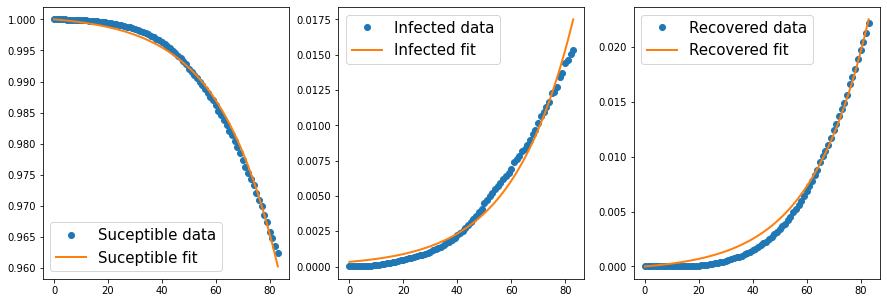

In [12]:
# Load data
t = np.arange(0, len(array_dia), 1)
data = np.array(datos_covid_SIR)

# set initial guess of parameters and their bounds
params = Parameters()
params.add('S0', value = datos_covid_SIR[0][0], min=0, max=1.0)
params.add('I0', value = datos_covid_SIR[0][1], min=0, max=1.0)
params.add('R0', value = datos_covid_SIR[0][2], min=0, max=1.0)
params.add('rr', value = 6.0, min=0, max=10)
params.add('a', value = 0.5, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(t, data[:,0], 'o', label="Suceptible data")
axs[0].plot(t, final[:,0], '-', linewidth=2, label="Suceptible fit")
axs[0].legend(fontsize = 15)
axs[1].plot(t, data[:,1], 'o', label="Infected data")
axs[1].plot(t, final[:,1], '-', linewidth=2, label="Infected fit")
axs[1].legend(fontsize = 15)
axs[2].plot(t, data[:,2], 'o', label="Recovered data")
axs[2].plot(t, final[:,2], '-', linewidth=2, label="Recovered fit")
axs[2].legend(fontsize = 15)

# display fitted statistics
report_fit(result)

## Run SIR model with obtained parameters

In [13]:
# Generate predicted data with SIR model and inferred parameters

# Get parameters from fitted model
rr = result.params.get('rr').value
a = result.params.get('a').value
true_params = np.array((rr,a))

# Set time and initial conditions
#S0_fitted = result.params.get('S0').value
#I0_fitted = result.params.get('I0').value
#R0_fitted = result.params.get('R0').value

t = np.arange(0, 5*len(array_dia), 1)
#x0 = np.array([S0_fitted, I0_fitted, R0_fitted])
x0 = datos_covid_SIR[0]

prediction_data = ODEsolution(x0, t, true_params)

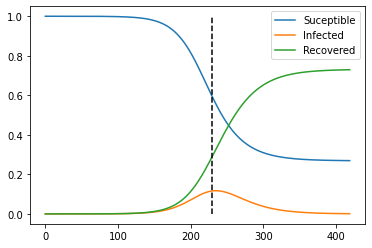

In [16]:
# Plot prediction data
plt.plot(t, prediction_data[:,0], label="Suceptible")
plt.plot(t, prediction_data[:,1], label="Infected")
plt.plot(t, prediction_data[:,2], label="Recovered")
plt.plot([230,230], [0,1],'--k')
plt.legend()